In [1]:
# COMPLETE ATTENTION EXTRACTION CODE

import sys
sys.path.append('/explore/nobackup/people/jacaraba/development/satvision-pix4d')

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import inspect
from scipy import ndimage

from satvision_pix4d.configs.config import _C, _update_config_from_file
from satvision_pix4d.pipelines import PIPELINES
from satvision_pix4d.datasets.abi_temporal_dataset import ABITemporalDataset
from torch.utils.data import DataLoader


[2025-08-06 13:48:18,165] [INFO] [real_accelerator.py:254:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2025-08-06 13:48:20,591] [INFO] [logging.py:107:log_dist] [Rank -1] [TorchCheckpointEngine] Initialized with serialization = False


In [2]:
# Step 1: Load the trained model and configuration
print("=" * 50)
print("STEP 1: LOADING MODEL")
print("=" * 50)

model_filename = '/explore/nobackup/projects/pix4dcloud/jacaraba/model_development/satmae/satmae_satvision_pix4d_pretrain-dev/satmae_satvision_pix4d_pretrain-dev/best-epoch=196-val_loss=47.0728.ckpt/checkpoint/mp_rank_00_model_states.pt'
config_filename = '/explore/nobackup/people/jacaraba/development/satvision-pix4d/tests/configs/test_satmae_dev.yaml'

# Load the configuration file and update it with model path
config = _C.clone()
_update_config_from_file(config, config_filename)
print("Loaded configuration file.")

config.defrost()
config.MODEL.PRETRAINED = model_filename
config.OUTPUT = '.'
config.freeze()
print("Updated configuration file.")

# Create the pipeline and load the model weights
pipeline = PIPELINES[config.PIPELINE]
ptlPipeline = pipeline(config)

checkpoint_data = torch.load(config.MODEL.PRETRAINED, map_location='cpu', weights_only=False)
model = ptlPipeline.load_checkpoint(config.MODEL.PRETRAINED, config)
model.cpu()
model.eval()

print("Model loaded successfully!")
print(f"Model type: {type(model)}")

# Check what parameters the model expects
sig = inspect.signature(model.forward)
print(f"Model forward parameters: {list(sig.parameters.keys())}")


STEP 1: LOADING MODEL
Loaded configuration file.
Updated configuration file.
Model loaded successfully!
Model type: <class 'satvision_pix4d.pipelines.satvision_pix4d_pretrain.SatVisionPix4DSatMAEPretrain'>
Model forward parameters: ['samples', 'timestamps']


In [3]:
# Step 2: Load satellite data for analysis
print("\n" + "=" * 50)
print("STEP 2: LOADING DATA")
print("=" * 50)

data_dir = '/explore/nobackup/people/jacaraba/projects/SatVision-Pix4d/tiles_pix4d/'

# Create dataset with 16-channel satellite imagery
dataset = ABITemporalDataset(
    data_paths=[data_dir], 
    img_size=512,
    in_chans=16,
    data_var='Rad'
)

print(f"Dataset created with {len(dataset)} samples")

# Load one batch of data
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
for batch in dataloader:
    imgs = batch
    break

print(f"Data loaded successfully!")
print(f"imgs type: {type(imgs)}")

# Handle different data formats that might come from the dataset
if isinstance(imgs, list):
    print(f"imgs is a list with {len(imgs)} elements")
    if len(imgs) > 0:
        if isinstance(imgs[0], torch.Tensor):
            try:
                imgs = torch.stack(imgs)
                print(f"Converted list to tensor: {imgs.shape}")
            except:
                imgs = imgs[0]
                print(f"Using first tensor from list: {imgs.shape}")
        else:
            print(f"First element type: {type(imgs[0])}")
            try:
                imgs = torch.tensor(imgs)
                print(f"Converted to tensor: {imgs.shape}")
            except Exception as e:
                print(f"Could not convert to tensor: {e}")
                imgs = None
elif isinstance(imgs, torch.Tensor):
    print(f"imgs is already a tensor: {imgs.shape}")
else:
    print(f"Unexpected imgs type: {type(imgs)}")
    try:
        imgs = torch.tensor(imgs)
        print(f"Forced conversion to tensor: {imgs.shape}")
    except Exception as e:
        print(f"Could not convert to tensor: {e}")
        imgs = None

if imgs is not None:
    print(f"Final imgs shape: {imgs.shape}")
    print(f"Final imgs type: {type(imgs)}")
else:
    print("Failed to load imgs as tensor")


STEP 2: LOADING DATA
Dataset created with 889 samples
Data loaded successfully!
imgs type: <class 'list'>
imgs is a list with 2 elements
Using first tensor from list: torch.Size([1, 6, 16, 512, 512])
Final imgs shape: torch.Size([1, 6, 16, 512, 512])
Final imgs type: <class 'torch.Tensor'>


In [4]:
# Step 3: Create timestamps and test model inference
print("\n" + "=" * 50)
print("STEP 3: CREATING TIMESTAMPS AND RUNNING INFERENCE")
print("=" * 50)

if imgs is None:
    print("Cannot create timestamps - imgs is None")
    timestamps = None
    pred_imgs = None
else:
    batch_size, time_steps = imgs.shape[0], imgs.shape[1]
    print(f"Batch size: {batch_size}, Time steps: {time_steps}")

    # Create simple sequential timestamps for the time series
    timestamps = torch.arange(time_steps).unsqueeze(0).expand(batch_size, -1)
    print(f"timestamps shape: {timestamps.shape}")
    print(f"timestamps: {timestamps}")

    # Try running the model to make sure everything works before attention extraction
    model.eval()
    with torch.no_grad():
        try:
            print("Attempting model inference...")
            model_output = model(samples=imgs, timestamps=timestamps)
            
            # Handle different types of model outputs
            if isinstance(model_output, tuple):
                print(f"Model returned tuple with {len(model_output)} elements")
                for i, output in enumerate(model_output):
                    if hasattr(output, 'shape'):
                        print(f"  Output {i}: {output.shape}")
                    else:
                        print(f"  Output {i}: {type(output)}")
                
                pred_imgs = model_output[0]
                print(f"Using first element as pred_imgs: {pred_imgs.shape}")
            else:
                pred_imgs = model_output
                print(f"Model inference successful!")
                print(f"pred_imgs shape: {pred_imgs.shape}")
                
            print(f"pred_imgs type: {type(pred_imgs)}")
            
        except Exception as e:
            print(f"Model inference failed: {e}")
            print(f"Error type: {type(e)}")
            import traceback
            traceback.print_exc()
            pred_imgs = None
            


STEP 3: CREATING TIMESTAMPS AND RUNNING INFERENCE
Batch size: 1, Time steps: 6
timestamps shape: torch.Size([1, 6])
timestamps: tensor([[0, 1, 2, 3, 4, 5]])
Attempting model inference...
Model returned tuple with 3 elements
  Output 0: torch.Size([])
  Output 1: torch.Size([1, 6144, 4096])
  Output 2: torch.Size([1, 6144])
Using first element as pred_imgs: torch.Size([])
pred_imgs type: <class 'torch.Tensor'>


In [5]:
# Step 4: Define functions for extracting and visualizing attention
print("\n" + "=" * 50)
print("STEP 4: DEFINING ATTENTION EXTRACTION FUNCTIONS")
print("=" * 50)

def get_last_self_attention(model, samples, timestamps, return_attn=True):
    """
    Extract attention weights from the model by trying different approaches
    """
    model.eval()
    
    with torch.no_grad():
        # Try approach 1: Check if model has a forward_encoder method with return_attn
        if hasattr(model, 'model') and hasattr(model.model, 'forward_encoder'):
            try:
                sig = inspect.signature(model.model.forward_encoder)
                if 'return_attn' in sig.parameters:
                    encoded, attn_weights = model.model.forward_encoder(samples, timestamps, return_attn=True)
                    print(f"Got attention from forward_encoder: {attn_weights.shape}")
                    return attn_weights
            except Exception as e:
                print(f"forward_encoder approach failed: {e}")
        
        # Try approach 2: Hook into attention modules during forward pass
        print("Searching for attention modules...")
        attention_modules = []
        for name, module in model.named_modules():
            module_name_lower = name.lower()
            module_type = str(type(module)).lower()
            
            # Look for modules with attention-related names
            if any(keyword in module_name_lower for keyword in ['attn', 'attention', 'self_attn']):
                attention_modules.append((name, module))
                print(f"Found attention module: {name} ({type(module)})")
            elif any(keyword in module_type for keyword in ['attention', 'multihead']):
                attention_modules.append((name, module))
                print(f"Found attention module by type: {name} ({type(module)})")
        
        if not attention_modules:
            print("No attention modules found")
            return None
        
        # Set up hooks to capture attention weights
        attn_weights = []
        
        def attention_hook(module, input, output):
            # Check if output contains attention weights (usually 4D tensor with square last two dims)
            if isinstance(output, tuple):
                for i, out in enumerate(output):
                    if hasattr(out, 'shape') and len(out.shape) == 4:
                        if out.shape[-1] == out.shape[-2] and out.shape[-1] > 1:
                            print(f"Captured attention from tuple element {i}: {out.shape}")
                            attn_weights.append(out)
            elif hasattr(output, 'shape') and len(output.shape) == 4:
                if output.shape[-1] == output.shape[-2] and output.shape[-1] > 1:
                    print(f"Captured attention from direct output: {output.shape}")
                    attn_weights.append(output)
            
            # Check if module stores attention weights as an attribute
            if hasattr(module, 'attn_weights'):
                print(f"Found stored attention weights: {module.attn_weights.shape}")
                attn_weights.append(module.attn_weights)
        
        # Register hooks on all attention modules
        hooks = []
        for name, module in attention_modules:
            hook = module.register_forward_hook(attention_hook)
            hooks.append(hook)
            print(f"Registered hook on: {name}")
        
        print(f"Registered {len(hooks)} hooks")
        
        # Run forward pass to trigger hooks
        try:
            output = model(samples=samples, timestamps=timestamps)
            print("Forward pass completed for attention extraction")
        except Exception as e:
            print(f"Forward pass failed during attention extraction: {e}")
        
        # Clean up hooks
        for hook in hooks:
            hook.remove()
        
        # Return the last captured attention weights (usually from the final layer)
        if attn_weights:
            print(f"Found {len(attn_weights)} attention tensors")
            for i, attn in enumerate(attn_weights):
                print(f"  Attention {i}: {attn.shape}")
            return attn_weights[-1]
        else:
            print("No attention weights captured")
            
            # Try approach 3: Direct access to transformer blocks
            print("Trying direct access to transformer blocks...")
            for name, module in model.named_modules():
                if hasattr(module, 'blocks'):
                    print(f"Found transformer blocks in: {name}")
                    try:
                        if hasattr(module, 'forward_encoder'):
                            result = module.forward_encoder(samples, return_attn=True)
                            if isinstance(result, tuple) and len(result) > 1:
                                return result[1]
                    except:
                        pass
            
            return None

def visualize_attention_on_image(image, attn, patch_size=16, head=0, cls_token=True, channel=0):
    """
    Overlay attention map on satellite image for visualization
    """
    # Convert image to numpy if needed
    if isinstance(image, torch.Tensor):
        image = image.detach().cpu().numpy()
    
    if len(image.shape) == 4:
        image = image[0]
    
    # Create RGB visualization from multi-channel satellite data
    if len(image.shape) == 3:
        if image.shape[0] >= 3:
            # Use channels 0, 5, 10 as RGB approximation
            rgb_channels = [0, 5, min(10, image.shape[0]-1)]
            display_image = np.zeros((image.shape[1], image.shape[2], 3))
            for i, ch in enumerate(rgb_channels):
                channel_data = image[ch]
                # Normalize using percentiles for better visualization
                p2, p98 = np.percentile(channel_data, [2, 98])
                if p98 > p2:
                    display_image[:, :, i] = np.clip((channel_data - p2) / (p98 - p2), 0, 1)
        else:
            # Single channel - convert to grayscale RGB
            display_image = image[channel]
            p2, p98 = np.percentile(display_image, [2, 98])
            if p98 > p2:
                display_image = np.clip((display_image - p2) / (p98 - p2), 0, 1)
            display_image = np.stack([display_image] * 3, axis=-1)
    else:
        display_image = image
    
    # Process attention weights
    if isinstance(attn, torch.Tensor):
        attn = attn.detach().cpu().numpy()
    
    attn_head = attn[head]
    
    # Use CLS token attention or average attention
    if cls_token:
        attn_map = attn_head[0, 1:]  # Skip CLS token in target
    else:
        attn_map = attn_head.mean(axis=0)[1:]
    
    # Reshape attention to spatial grid
    num_patches = attn_map.shape[0]
    grid_size = int(np.sqrt(num_patches))
    
    if grid_size * grid_size != num_patches:
        print(f"Warning: Cannot reshape {num_patches} patches into square grid")
        grid_size = int(np.sqrt(num_patches))
        attn_map = attn_map[:grid_size*grid_size]
    
    attn_map = attn_map.reshape(grid_size, grid_size)
    
    # Normalize attention map
    if attn_map.max() > attn_map.min():
        attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())
    
    # Upsample attention map to match image size
    attn_map = np.kron(attn_map, np.ones((patch_size, patch_size)))
    
    # Resize to exactly match image dimensions
    img_h, img_w = display_image.shape[:2]
    if attn_map.shape[0] != img_h or attn_map.shape[1] != img_w:
        attn_map = ndimage.zoom(attn_map, (img_h/attn_map.shape[0], img_w/attn_map.shape[1]))
    
    # Create visualization with three panels
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(display_image)
    axes[0].set_title('Original Satellite Image')
    axes[0].axis('off')
    
    im1 = axes[1].imshow(attn_map, cmap='jet')
    axes[1].set_title(f'Attention Map (Head {head})')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1])
    
    axes[2].imshow(display_image)
    axes[2].imshow(attn_map, cmap='jet', alpha=0.4)
    axes[2].set_title('Attention Overlay')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return attn_map

def visualize_multiple_heads(image, attn, patch_size=16, num_heads=8):
    """
    Show attention patterns from multiple attention heads
    """
    if isinstance(attn, torch.Tensor):
        attn = attn.detach().cpu().numpy()
    
    num_heads = min(num_heads, attn.shape[0])
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for head in range(num_heads):
        attn_head = attn[head]
        attn_map = attn_head[0, 1:]  # CLS token attention
        
        # Reshape to spatial grid
        num_patches = attn_map.shape[0]
        grid_size = int(np.sqrt(num_patches))
        if grid_size * grid_size != num_patches:
            grid_size = int(np.sqrt(num_patches))
            attn_map = attn_map[:grid_size*grid_size]
        
        attn_map = attn_map.reshape(grid_size, grid_size)
        
        # Normalize
        if attn_map.max() > attn_map.min():
            attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())
        
        if head < len(axes):
            im = axes[head].imshow(attn_map, cmap='jet')
            axes[head].set_title(f'Head {head}')
            axes[head].axis('off')
            plt.colorbar(im, ax=axes[head])
    
    plt.tight_layout()
    plt.show()

def extract_and_visualize_attention(model, imgs, timestamps, sample_idx=0, timestep=0):
    """
    Main function to extract attention and create visualizations
    """
    print("Extracting attention weights...")
    print(f"Input shape: {imgs.shape}")
    print(f"Timestamps shape: {timestamps.shape}")
    
    attn_weights = get_last_self_attention(model, imgs, timestamps)
    
    if attn_weights is not None:
        print(f"Attention weights extracted: {attn_weights.shape}")
        
        # Get the image for visualization
        viz_image = imgs[sample_idx, timestep]
        print(f"Visualization image shape: {viz_image.shape}")
        
        # Create single head visualization
        print("Creating attention visualization...")
        attn_map = visualize_attention_on_image(
            viz_image, 
            attn_weights[sample_idx], 
            patch_size=16, 
            head=0
        )
        
        # Create multi-head visualization if multiple heads exist
        if attn_weights.shape[1] > 1:
            print("Visualizing multiple attention heads...")
            visualize_multiple_heads(
                viz_image, 
                attn_weights[sample_idx], 
                patch_size=16, 
                num_heads=min(8, attn_weights.shape[1])
            )
        
        return attn_weights
    else:
        print("Could not extract attention weights from model")
        return None


STEP 4: DEFINING ATTENTION EXTRACTION FUNCTIONS



STEP 5: RUNNING ATTENTION EXTRACTION
Checking variables...
model: <class 'satvision_pix4d.pipelines.satvision_pix4d_pretrain.SatVisionPix4DSatMAEPretrain'>
imgs: torch.Size([1, 6, 16, 512, 512])
timestamps: torch.Size([1, 6])
pred_imgs: torch.Size([])

RUNNING ATTENTION EXTRACTION...
Extracting attention weights...
Input shape: torch.Size([1, 6, 16, 512, 512])
Timestamps shape: torch.Size([1, 6])
Searching for attention modules...
Found attention module: model.blocks.0.attn (<class 'satvision_pix4d.models.encoders.models_mae_temporal.FlashMHAWrapper'>)
Found attention module: model.blocks.0.attn.attn (<class 'flash_attn.modules.mha.MHA'>)
Found attention module: model.blocks.0.attn.attn.Wqkv (<class 'torch.nn.modules.linear.Linear'>)
Found attention module: model.blocks.0.attn.attn.inner_attn (<class 'flash_attn.modules.mha.SelfAttention'>)
Found attention module: model.blocks.0.attn.attn.inner_attn.drop (<class 'torch.nn.modules.dropout.Dropout'>)
Found attention module: model.blocks

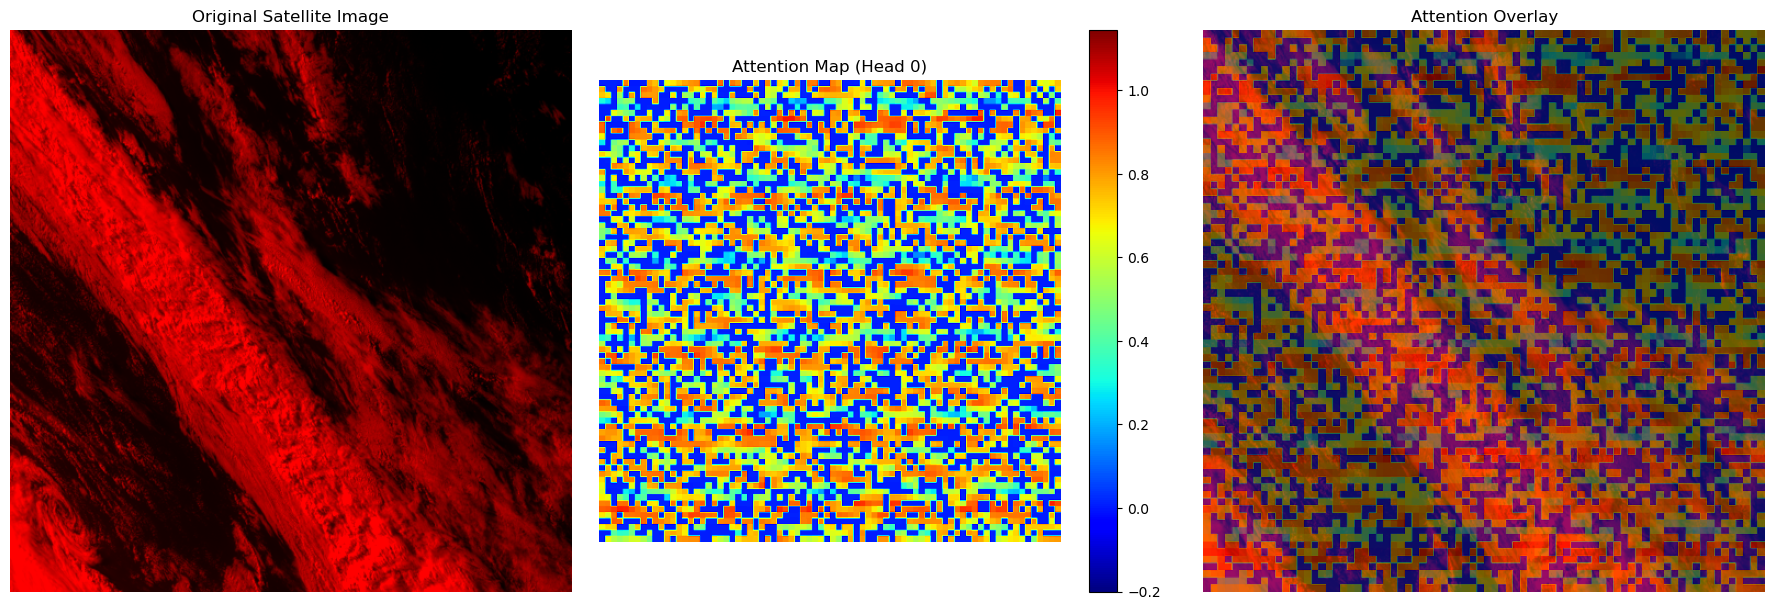

Visualizing multiple attention heads...


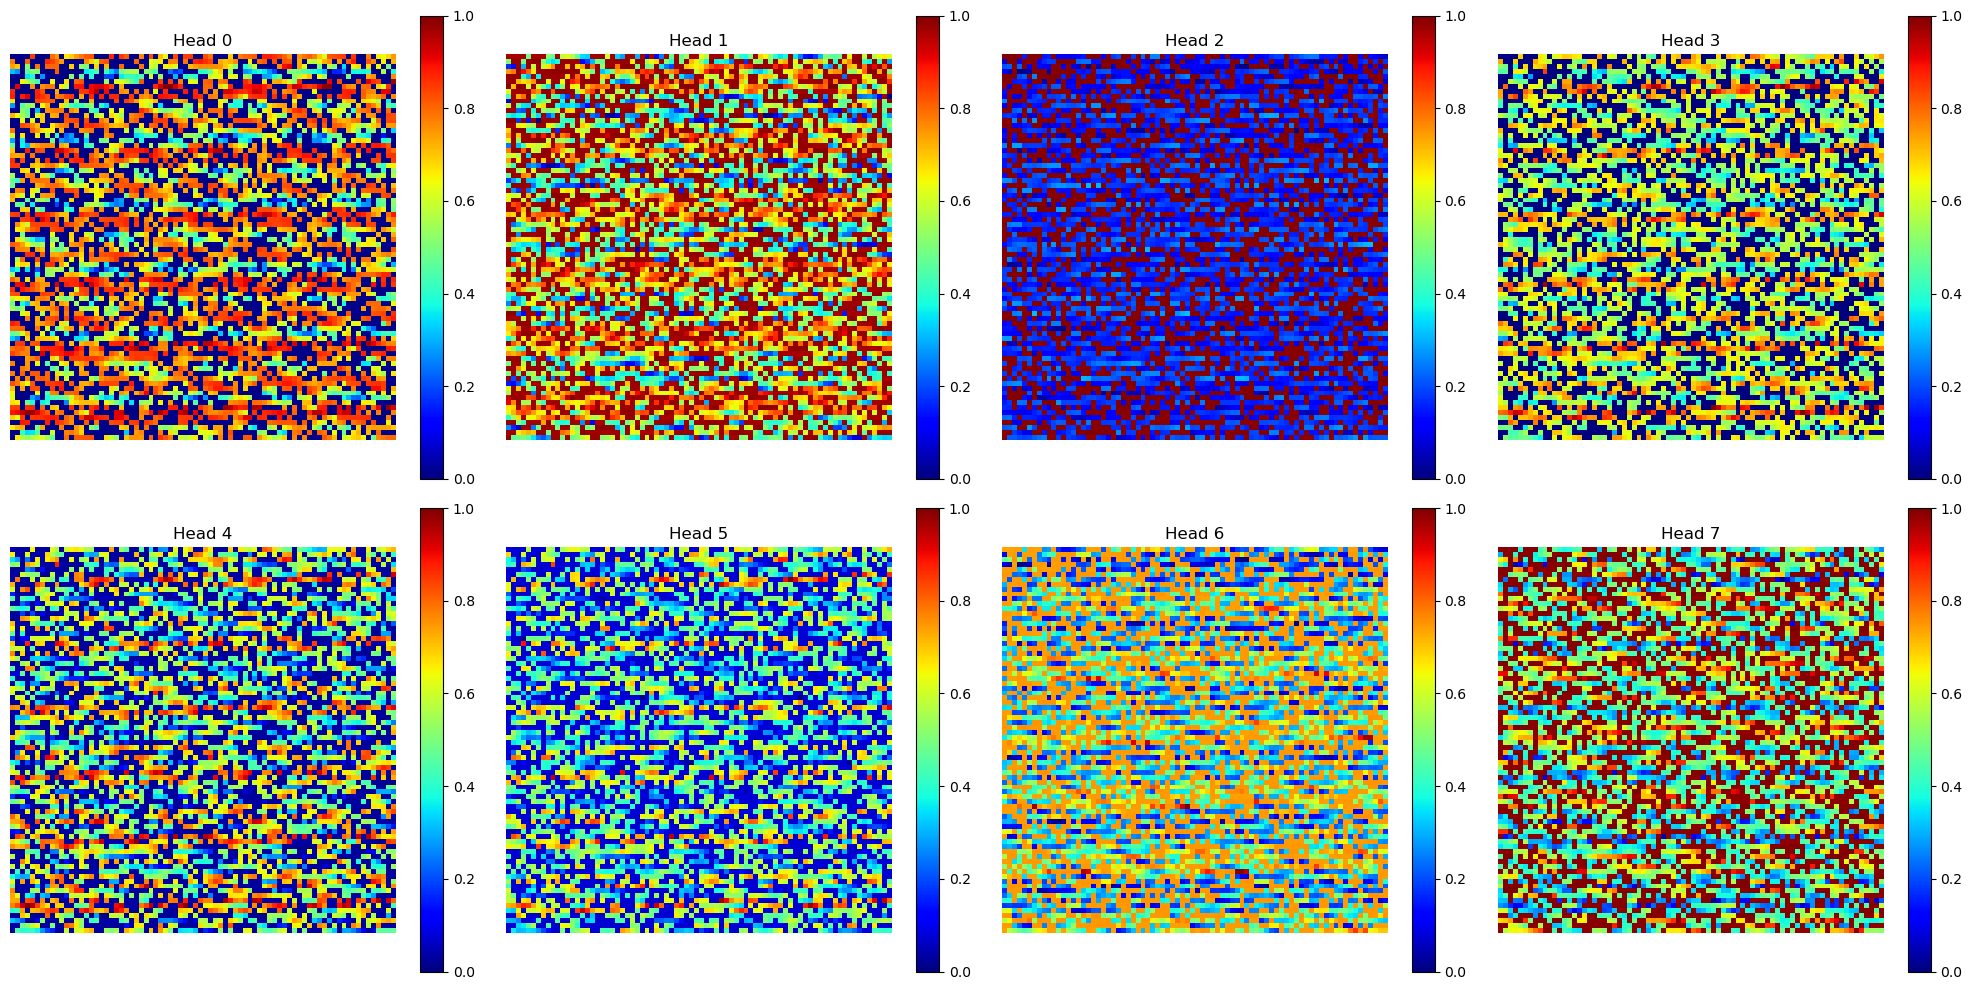


SUCCESS! Attention extraction completed.
Final attention shape: torch.Size([1, 16, 6145, 6145])


In [6]:
# Step 5: Run the complete attention extraction and visualization pipeline
print("\n" + "=" * 50)
print("STEP 5: RUNNING ATTENTION EXTRACTION")
print("=" * 50)

# Check that all required variables are available
print("Checking variables...")
variables_ok = True

if 'model' not in locals():
    print("model not found")
    variables_ok = False
else:
    print(f"model: {type(model)}")

if 'imgs' not in locals():
    print("imgs not found") 
    variables_ok = False
elif imgs is None:
    print("imgs is None")
    variables_ok = False
else:
    print(f"imgs: {imgs.shape}")

if 'timestamps' not in locals():
    print("timestamps not found")
    variables_ok = False
elif timestamps is None:
    print("timestamps is None")
    variables_ok = False
else:
    print(f"timestamps: {timestamps.shape}")

if 'pred_imgs' not in locals():
    print("pred_imgs not found (but we can work without it)")
elif pred_imgs is None:
    print("pred_imgs is None (model inference failed, but we can still extract attention)")
else:
    print(f"pred_imgs: {pred_imgs.shape}")

# Run attention extraction if everything looks good
if variables_ok:
    print("\nRUNNING ATTENTION EXTRACTION...")
    attention_weights = extract_and_visualize_attention(
        model, 
        imgs, 
        timestamps, 
        sample_idx=0, 
        timestep=0
    )
    
    if attention_weights is not None:
        print("\nSUCCESS! Attention extraction completed.")
        print(f"Final attention shape: {attention_weights.shape}")
    else:
        print("\nAttention extraction failed.")
else:
    print("Missing required variables - check the steps above for errors")
    print("\nDebugging info:")
    print(f"  model exists: {'model' in locals()}")
    print(f"  imgs exists: {'imgs' in locals()}")
    print(f"  imgs is not None: {imgs is not None if 'imgs' in locals() else 'N/A'}")
    print(f"  timestamps exists: {'timestamps' in locals()}")
    print(f"  timestamps is not None: {timestamps is not None if 'timestamps' in locals() else 'N/A'}")